## Python-gmt Test with FOCI Data from ERDDAP
### erddapy example for PMEL tools - Drifters

__pyversion__==3.6   
__author__==S.Bell

#### Basic Python Imports

In [1]:
from erddapy import ERDDAP
import numpy as np
import datetime

import pandas as pd


In [2]:
today = datetime.datetime.now()
print(today.strftime('%Y%m%d'))

20201210


### Connect to erddap Server and retrieve data

Get only ARGOS Drifter datafiles from akutan erddap server

In [3]:
server_url='http://akutan.pmel.noaa.gov:8080/erddap'
# The NRT data is being tested on Akutan, but also available on downdraft
#server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

In [4]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='argos and drifter and NRT'))

In [5]:
argos = df['Dataset ID'].values
print(f"Available erddap datasets {argos}")

Available erddap datasets ['2015_Argos_Drifters_NRT' '2016_Argos_Drifters_NRT'
 '2017_Argos_Drifters_NRT' '2018_Argos_Drifters_NRT'
 '2019_Argos_Drifters_NRT' '2020_Argos_Drifters_NRT']


In [24]:
kw = {
    'min_lon': -180,
    'max_lon': 540,
    'min_lat': 45.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': '2020-01-10T00:00:00Z',
    'cdm_data_type': 'trajectory'
}

In [25]:
variables = [e.get_var_by_attr(dataset_id=float, 
            long_name=lambda v: v is not None) for float in argos]

common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.update(['trajectory_id']) 
common_variables

{'latitude',
 'lon360',
 'longitude',
 'sst',
 'strain',
 'time',
 'trajectory_id',
 'voltage'}

Using the bounds and variables created above, generate the ReSTfull url to retrieve the erddap data.  The resulting link will retrieve a csv file of the specifide data.

In [26]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

http://akutan.pmel.noaa.gov:8080/erddap/tabledap/2015_Argos_Drifters_NRT.csv?voltage,sst,trajectory_id,time,lon360,strain,latitude,longitude&longitude>=-180&longitude<=540&latitude>=45.0&latitude<=90.0&time>=1420848000.0&time<=1578614400.0


Alternatively, we can ingest it directly into a pandas dataframe to be manipulated and plotted.

In [27]:

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat

        dft = e.to_pandas(index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
        dft.columns = [x[1].split()[0] for x in enumerate(dft.columns)]
        dfs.update({arfloat: dft})
    except:
        pass

2015_Argos_Drifters_NRT
2016_Argos_Drifters_NRT
2017_Argos_Drifters_NRT
2018_Argos_Drifters_NRT
2019_Argos_Drifters_NRT
2020_Argos_Drifters_NRT


In [28]:
print("Listing all Argos ID's in the chosen year dataset:")
for float, df in dfs.items():
    id_list = list(df.groupby('trajectory_id').groups.keys())
    id_str_list=[str(x).lstrip() for x in id_list]
    print(float, "\n\t" + "\n\t".join(id_str_list))
    


Listing all Argos ID's in the chosen year dataset:
2015_Argos_Drifters_NRT 
	122533
	122537
	122542
	122843
	122845
	122846
	122847
	136859
	136860
	136861
	136862
	136863
	136864
	136865
	136866
	136867
	136868
	136869
	136870
	136871
	136873
	136874
	148276
	148277
	148278
	148279
2016_Argos_Drifters_NRT 
	136861
	136864
	136865
	136872
	136873
	136874
	148276
	148277
	148279
2017_Argos_Drifters_NRT 
	122537
	122540
	122541
	122542
	136860
	136863
	136866
	136867
	136868
	136869
	136872
	145474
	148276
	148277
2018_Argos_Drifters_NRT 
	136863
	136866
	136867
	136868
	139910
	139911
	139912
	139913
	139914
	139915
	145469
	145473
	145474
	145480
	148276
2019_Argos_Drifters_NRT 
	136863
	136867
	145469
	145473
	145480
	148276
2020_Argos_Drifters_NRT 
	136863


In [29]:
dfg = dfs['2018_Argos_Drifters_NRT'].groupby('trajectory_id')
for traj in dfg.groups.keys():
    dfg.get_group(traj)
    print("Last Report Time for {id} was {time}".format(id=traj,
                                                        time=dfg.get_group(traj).index[-1]))

Last Report Time for 136863 was 2018-12-31 22:03:00+00:00
Last Report Time for 136866 was 2018-08-15 03:05:00+00:00
Last Report Time for 136867 was 2018-12-31 22:47:00+00:00
Last Report Time for 136868 was 2018-07-06 01:38:00+00:00
Last Report Time for 139910 was 2018-09-15 21:55:00+00:00
Last Report Time for 139911 was 2018-11-27 04:02:00+00:00
Last Report Time for 139912 was 2018-11-19 14:16:00+00:00
Last Report Time for 139913 was 2018-11-14 17:38:00+00:00
Last Report Time for 139914 was 2018-09-15 08:16:00+00:00
Last Report Time for 139915 was 2018-09-11 06:46:00+00:00
Last Report Time for 145469 was 2018-12-31 22:54:00+00:00
Last Report Time for 145473 was 2018-12-31 23:39:00+00:00
Last Report Time for 145474 was 2018-07-27 00:52:00+00:00
Last Report Time for 145480 was 2018-12-31 23:32:00+00:00
Last Report Time for 148276 was 2018-12-31 23:33:00+00:00


## Plotting Via Cartopy

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


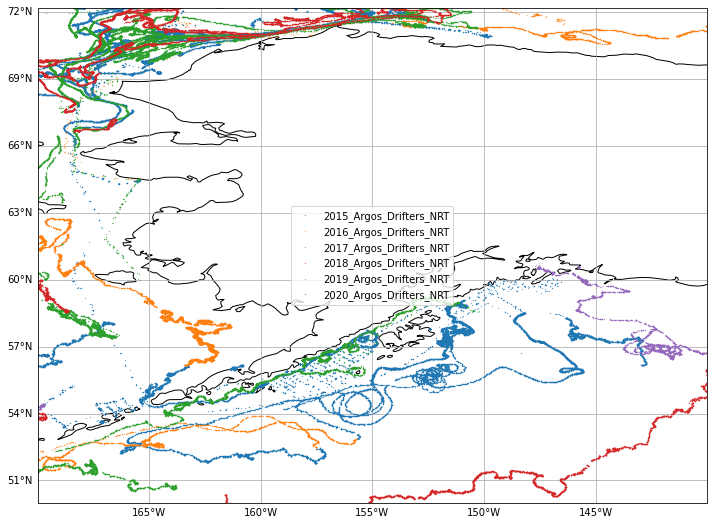

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    """subroutine to specify basemap"""
    fig, ax = plt.subplots(figsize=(12,12),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
projection=ccrs.PlateCarree()
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-170, -140, 50, 72]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

## Plotting Via GMT-Python (unstable but asthetically pleasing plots)

This test package is not available for windows

In [37]:
import pygmt

In [53]:
fig = pygmt.Figure()

fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

fig1 = pygmt.Figure()
fig1.coast(region=[-175, -145, 65, 75], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)


In [54]:
#group by trajectory_id which is the argos transmission id
dfg = dfs['2019_Argos_Drifters_NRT'].groupby('trajectory_id')

#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray','white']
count=0
for traj in dfg.groups.keys():
    fig.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    fig1.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count]+"\t : \t"+str(traj))
    count+=1

red	 : 	136863
black	 : 	145473
blue	 : 	148276


In [55]:
dfs['2019_Argos_Drifters_NRT']

,lon360,latitude,sst,longitude,voltage,trajectory_id,strain
time (UTC),,,,,,,
2019-01-01 05:36:00+00:00,163.329,56.360,-2.0,163.329,13.8,136863,1.0
2019-01-01 07:02:00+00:00,163.329,56.360,-2.0,163.329,13.8,136863,1.0
2019-01-01 07:09:00+00:00,163.328,56.360,-2.0,163.328,13.8,136863,1.0
2019-01-01 07:56:00+00:00,163.330,56.361,-2.0,163.330,13.8,136863,1.0
2019-01-01 09:16:00+00:00,163.330,56.360,-2.0,163.330,13.8,136863,1.0
...,...,...,...,...,...,...,...
2019-05-12 15:52:00+00:00,179.968,58.836,3.4,179.968,8.8,148276,0.0
2019-05-12 17:28:00+00:00,179.984,58.829,3.4,179.984,8.8,148276,0.0
2019-05-12 17:45:00+00:00,179.988,58.828,3.4,179.988,8.8,148276,0.0


### Show by ID

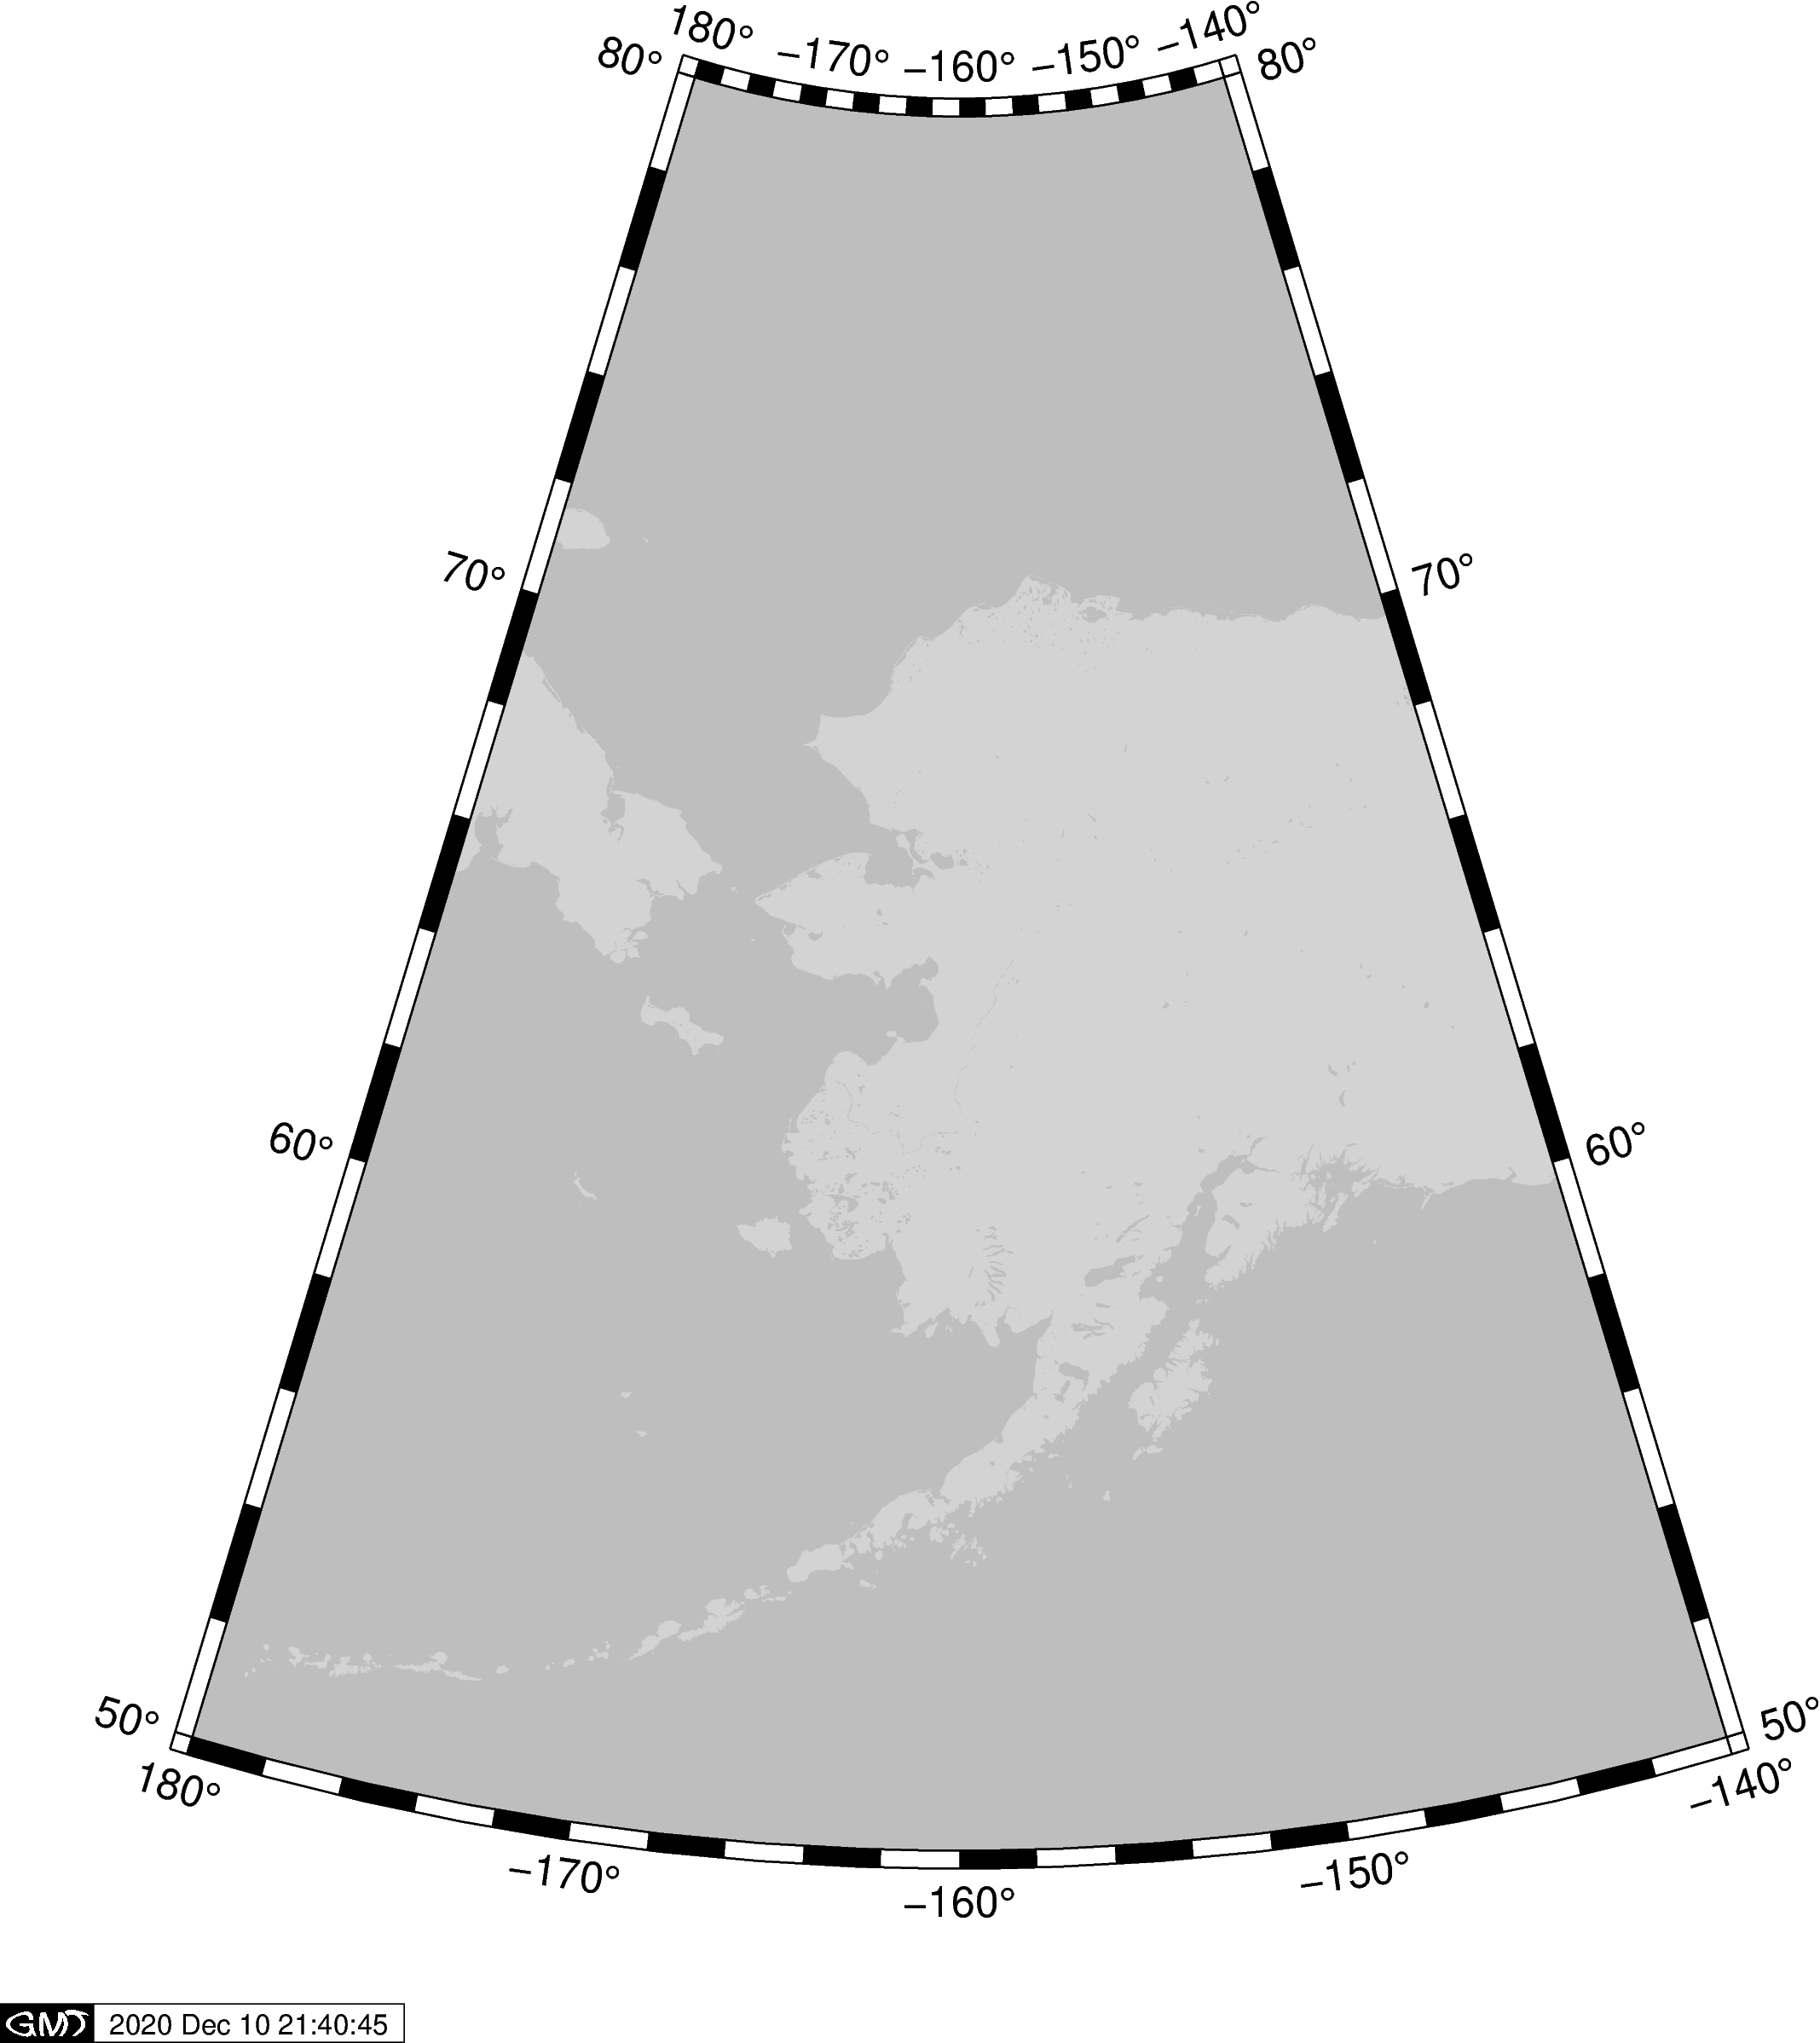

In [56]:
fig.show()


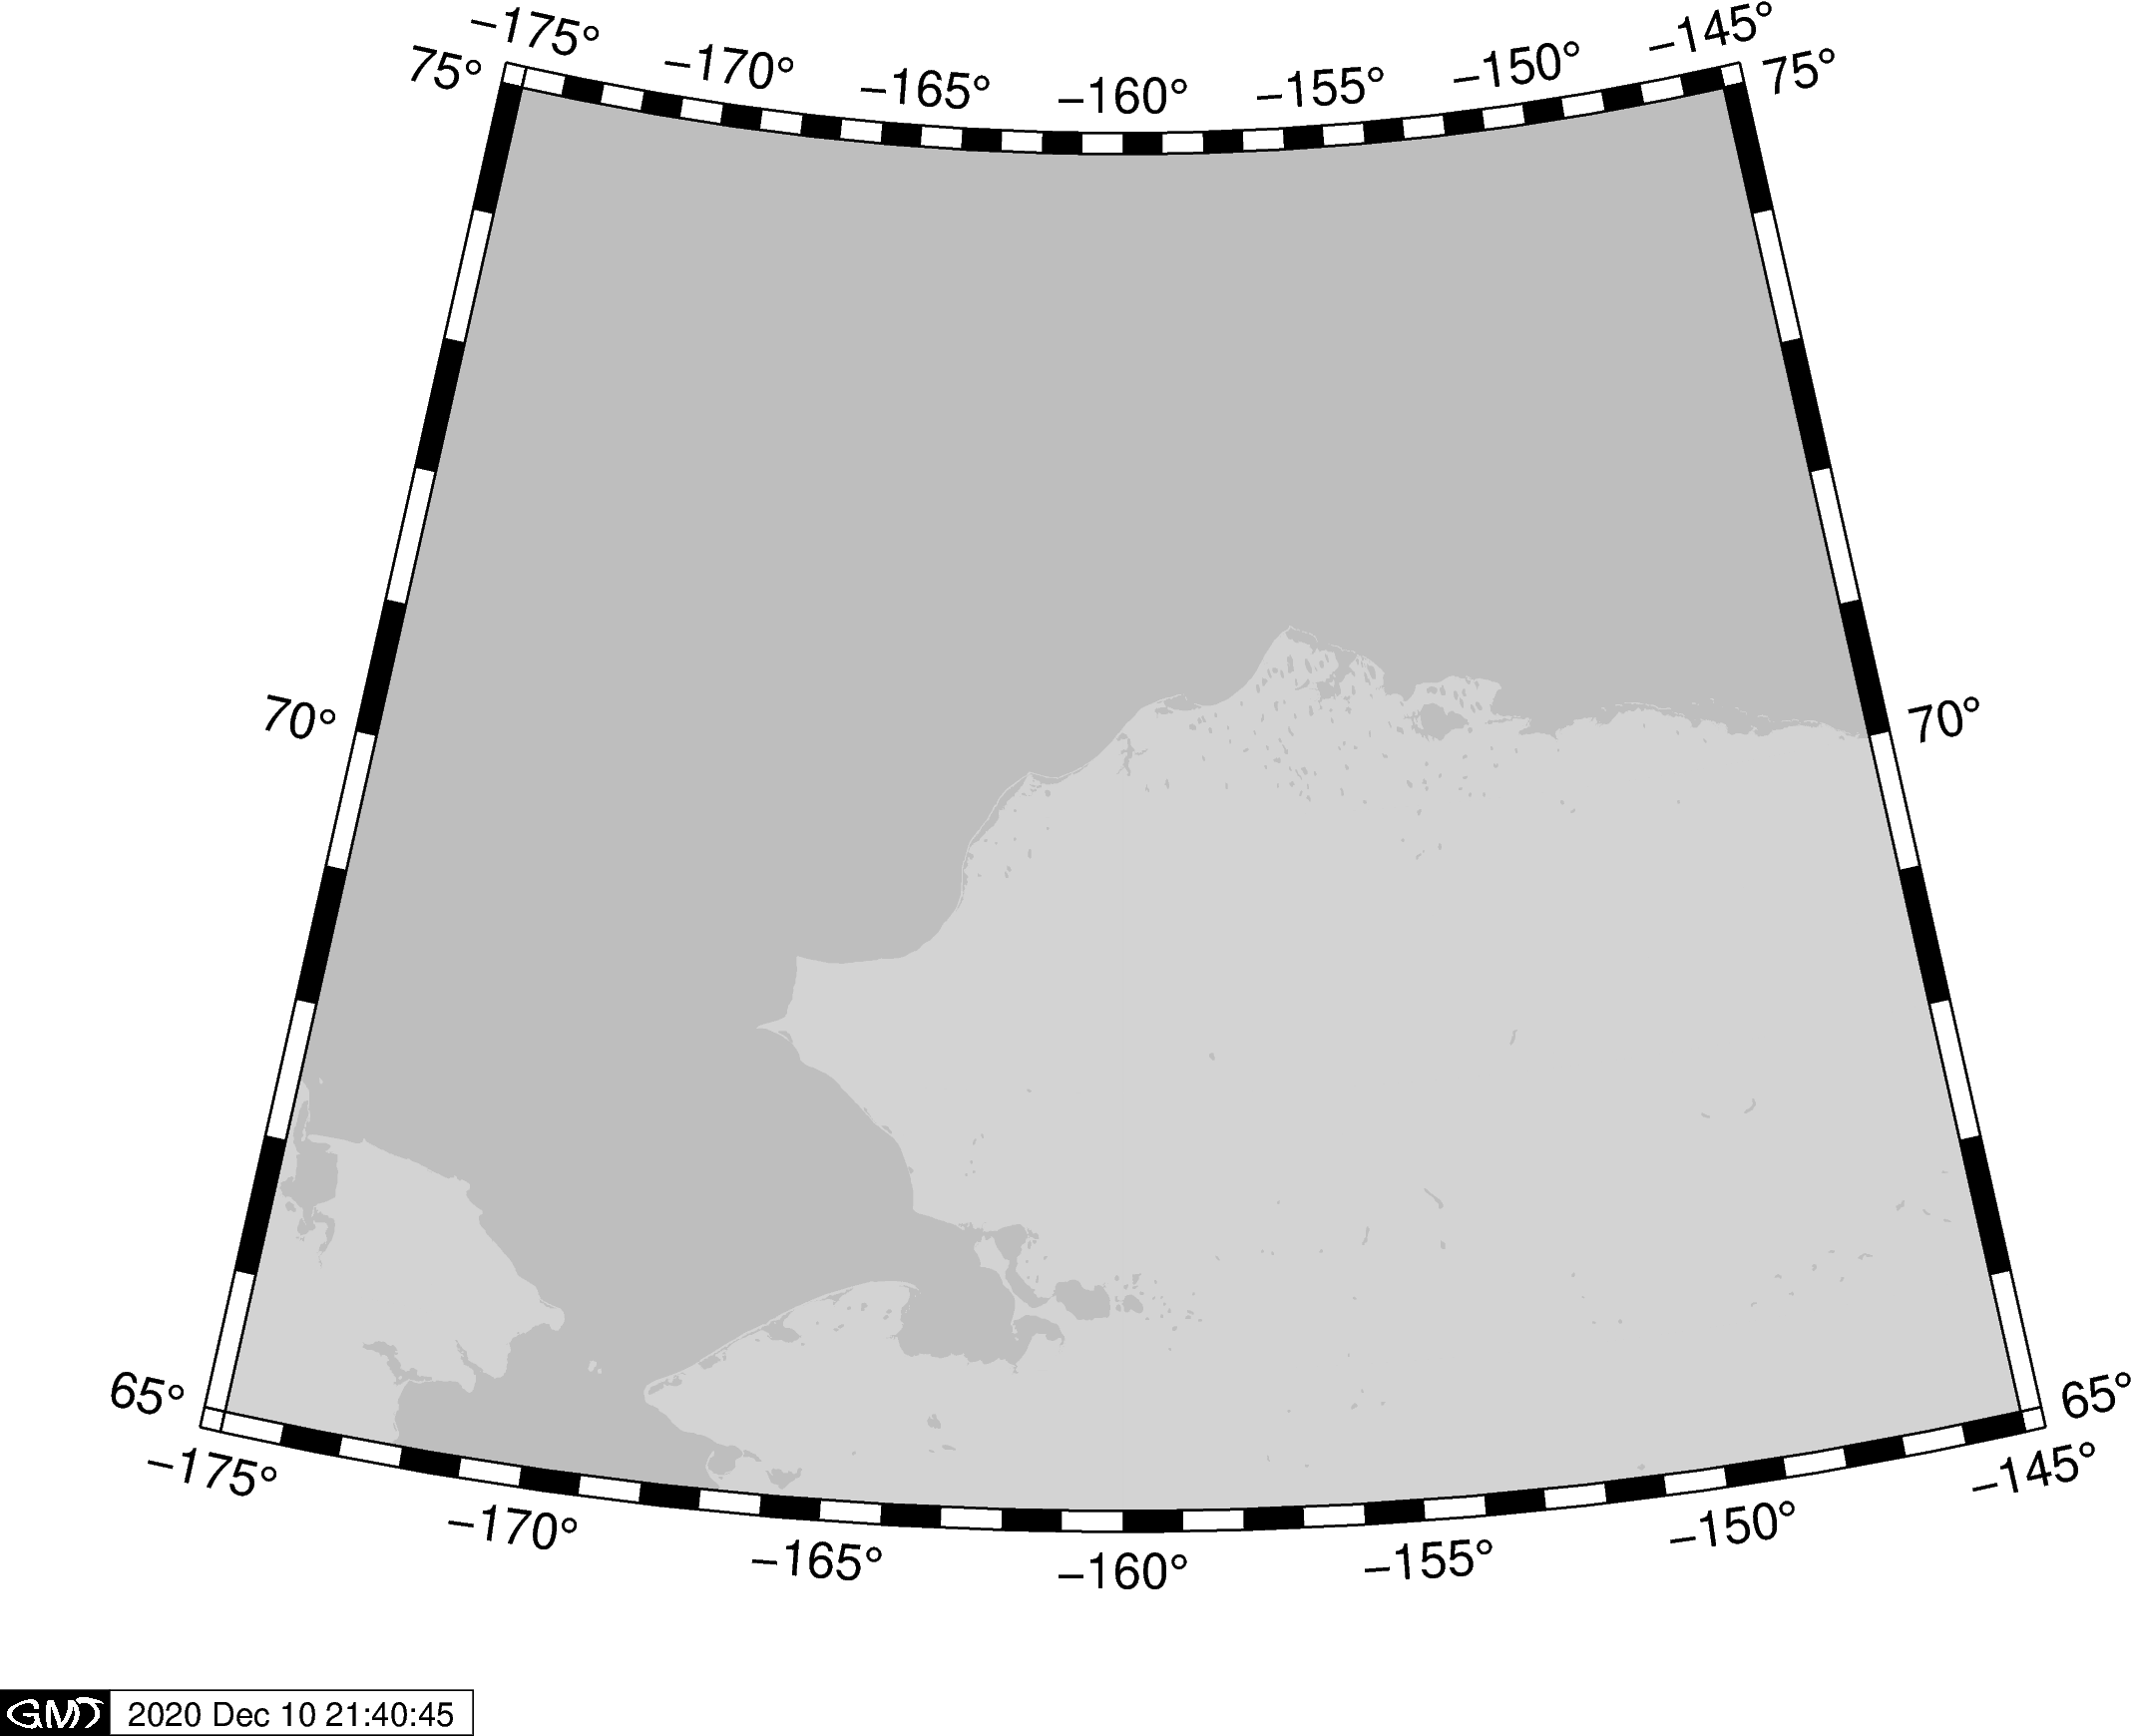

In [57]:
fig1.show()

In [58]:
fig1.savefig('ARGOS_Drifters_Chukchi_'+today.strftime('%Y%m%d')+'.png')

In [60]:
fig1b = pygmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

#color by id for one year
clist=['red','black','blue','green','cyan','yellow','orange','lightred','lightgray',
      'lightblue','lightgreen','lightyellow','brown','darkgray','white']
count=0
for traj in dfg.groups.keys():
    fig1b.plot(x=dfg.get_group(traj).longitude, y=dfg.get_group(traj).latitude, color=clist[count], style='p0.05')
    print(clist[count]+"\t : \t"+str(traj))
    count+=1

red	 : 	136863
black	 : 	145473
blue	 : 	148276


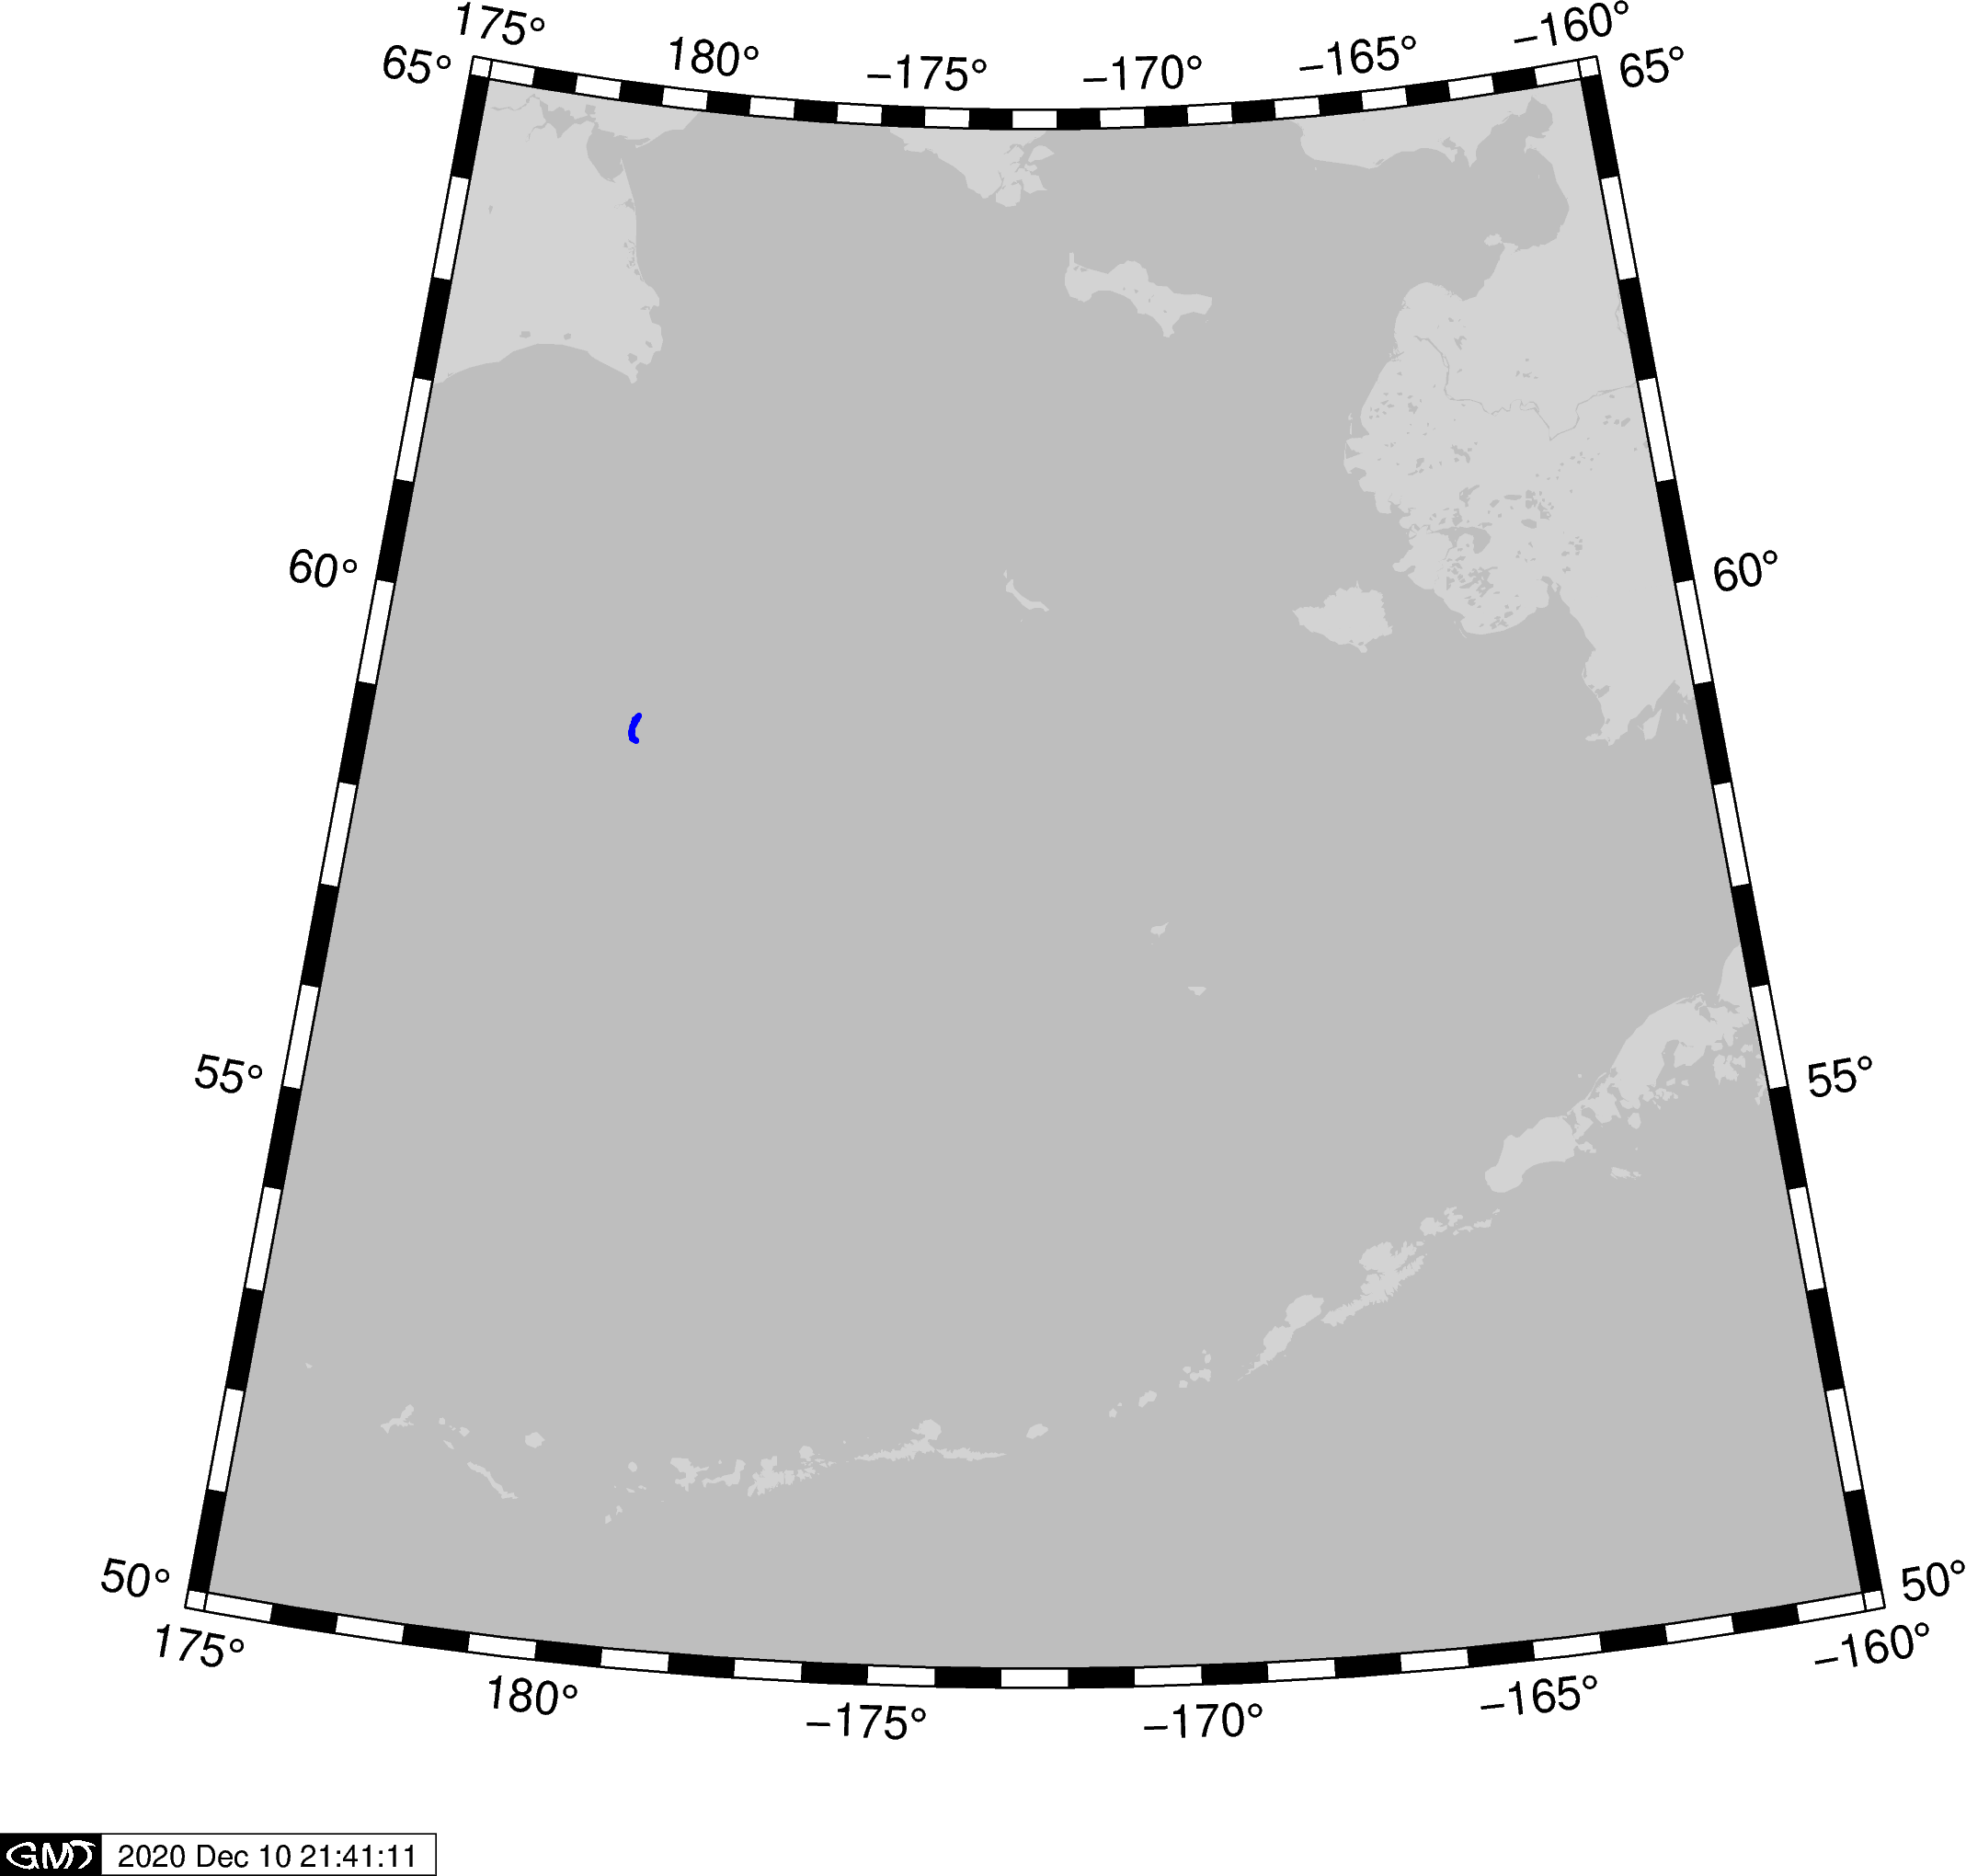

In [61]:
fig1b.show()

In [62]:
fig1b.savefig('ARGOS_Drifters_Bering_'+today.strftime('%Y%m%d')+'.png')

In [64]:
fig1 = pygmt.Figure()

fig1.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

Using the cmocean colormaps for gmt found at http://soliton.vm.bytemark.co.uk/pub/cpt-city/cmocean/ (these must be installed in the {conda}/{gmt_env}/share/gmt/cpt/ path where conda is the path to your conda installation and gmt_env is the environment gmt is running in)

### Show by SST

In [65]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


/Users/bell/miniconda3/envs/pygmt/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt was not found
plot [ERROR]: Cannot find file /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt not found
[Session pygmt-session (60)]: Error returned from GMT API: GMT_FILE_NOT_FOUND (16)


GMTCLibError: Module 'plot' failed with status code 16:
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt was not found
plot [ERROR]: Cannot find file /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt not found

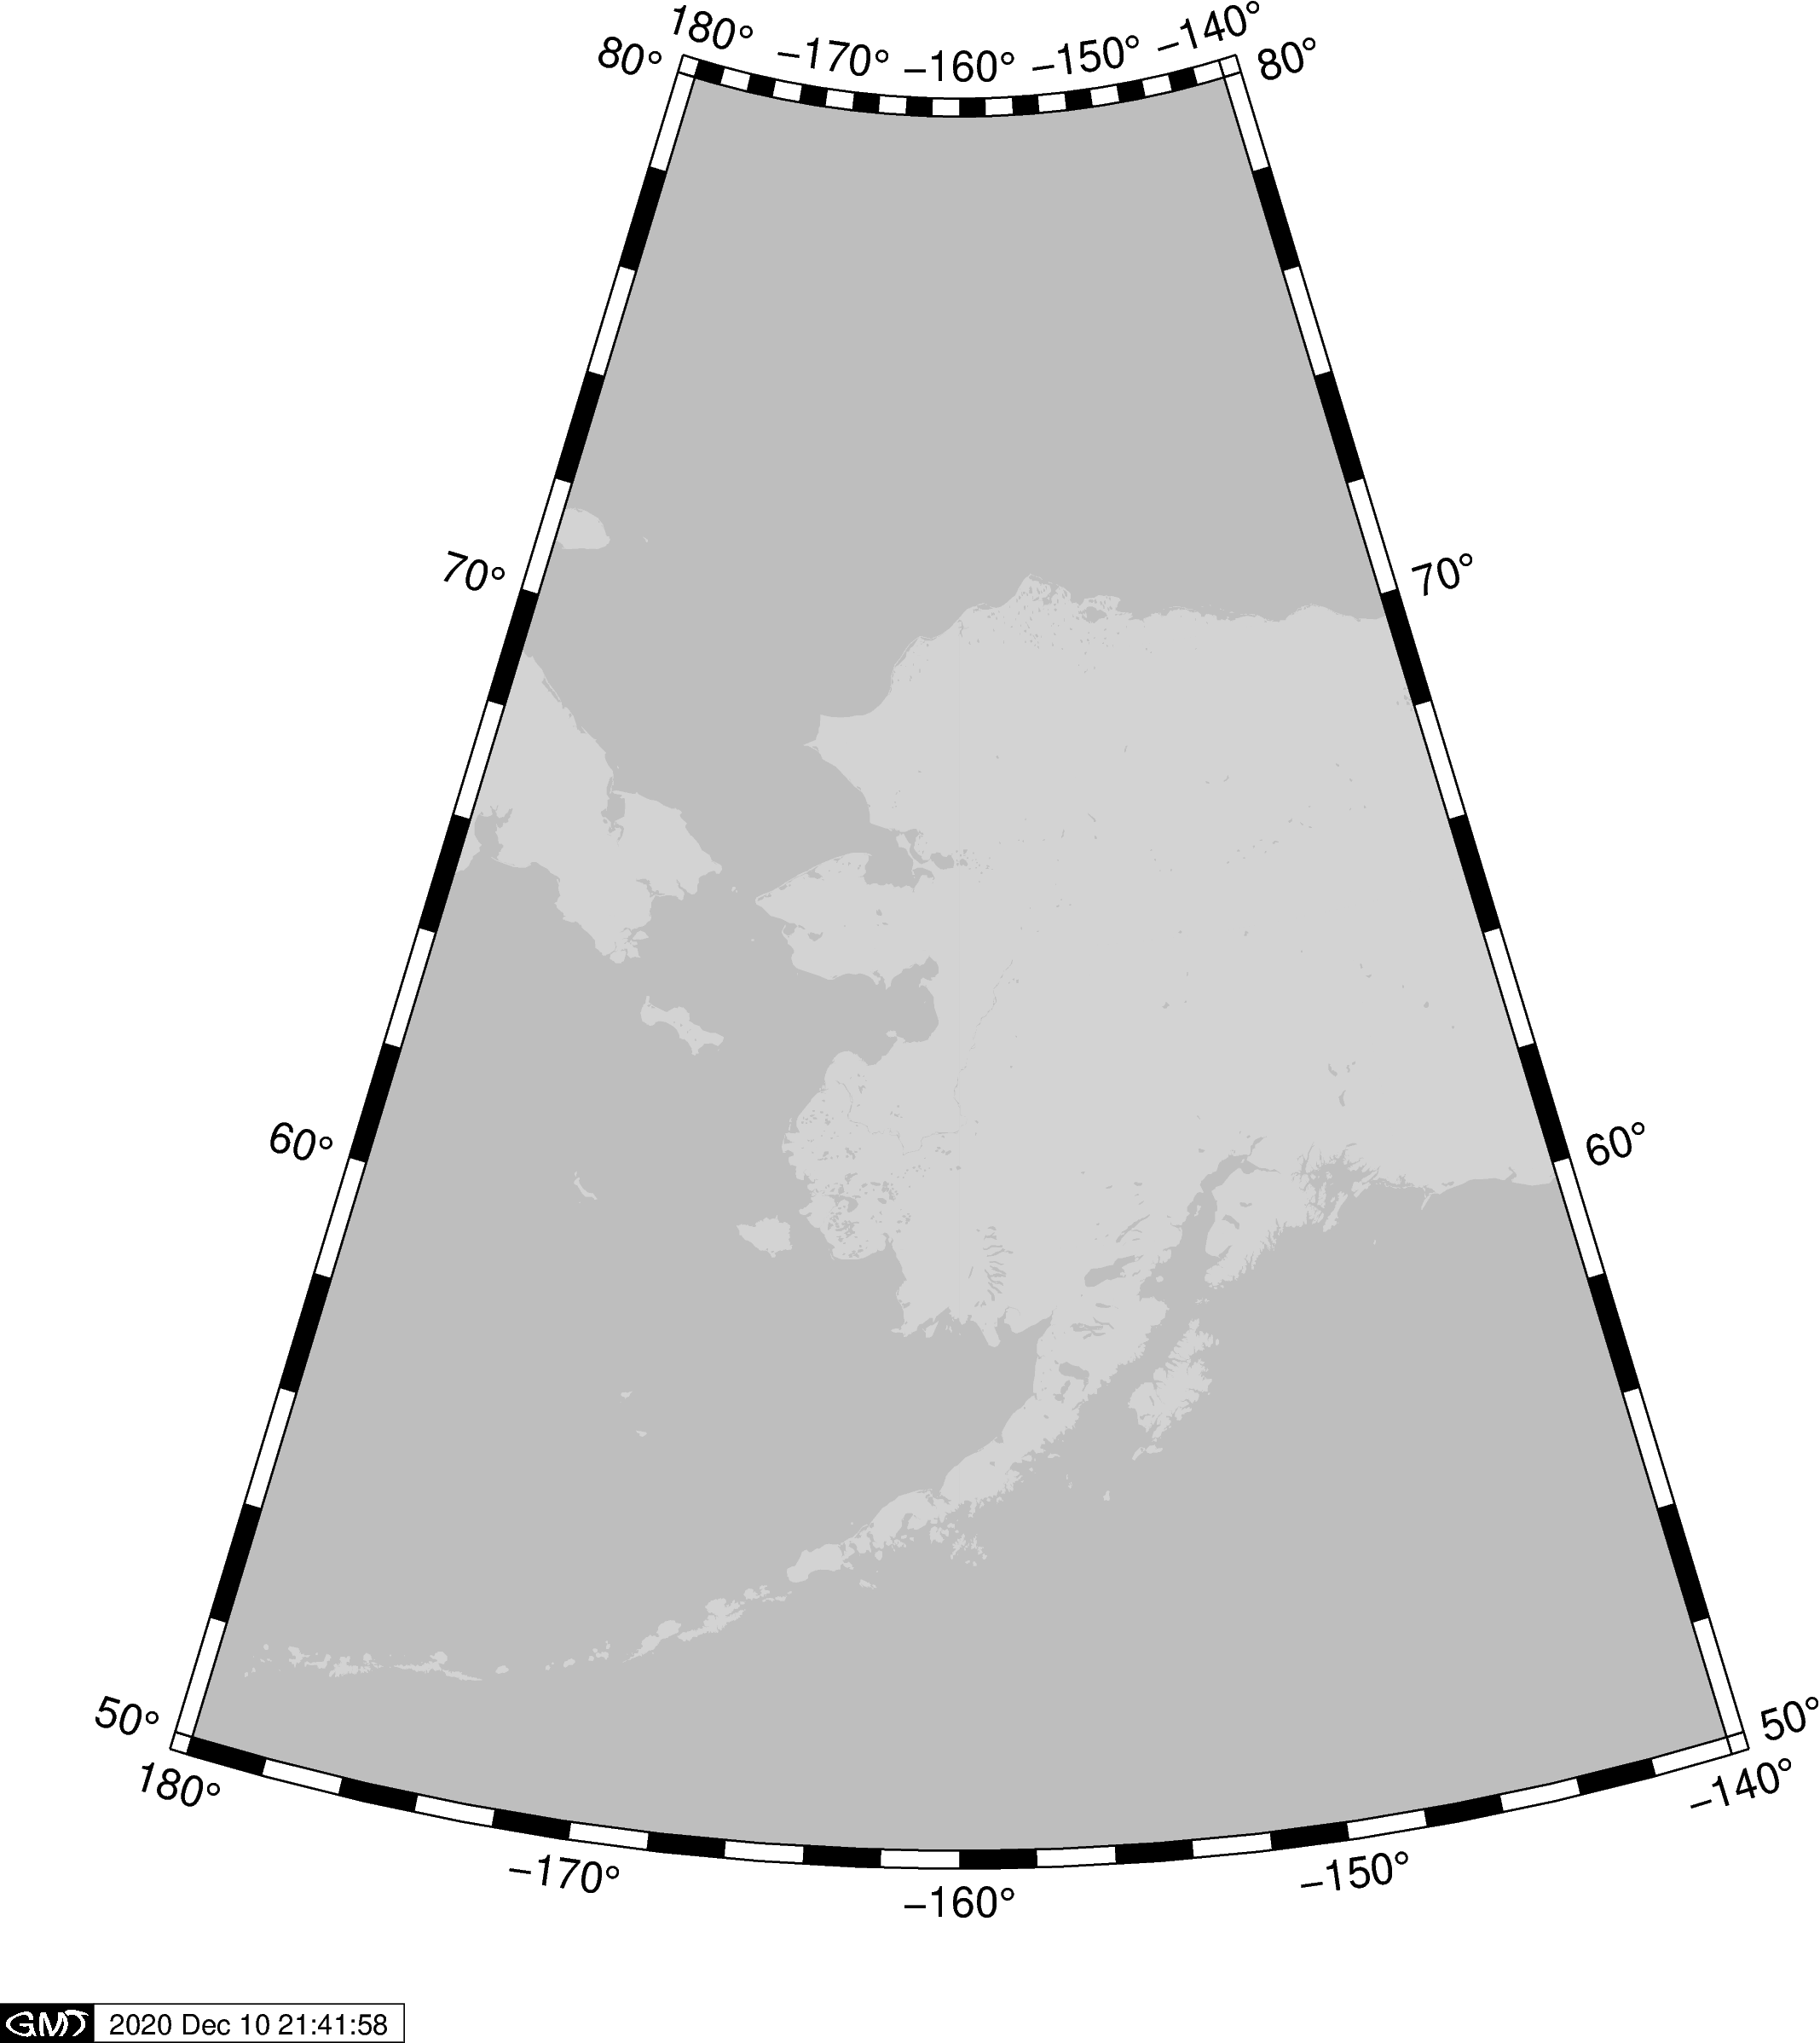

In [66]:
fig1.show()

### Zoom in to Basins (Arctic and Bering) - SST

In [68]:
fig1 = pygmt.Figure()
fig1.coast(region=[-175, -155, 65, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

fig1b = pygmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [69]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.sst.loc[(df.sst > 15) | (df.sst <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')
    fig1b.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.sst, cmap='thermal', style='c0.05c')


/Users/bell/miniconda3/envs/pygmt/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt was not found
plot [ERROR]: Cannot find file /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt not found
[Session pygmt-session (70)]: Error returned from GMT API: GMT_FILE_NOT_FOUND (16)


GMTCLibError: Module 'plot' failed with status code 16:
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt was not found
plot [ERROR]: Cannot find file /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt
plot [ERROR]: File /Users/bell/miniconda3/envs/pygmt/share/gmt/thermal.cpt not found

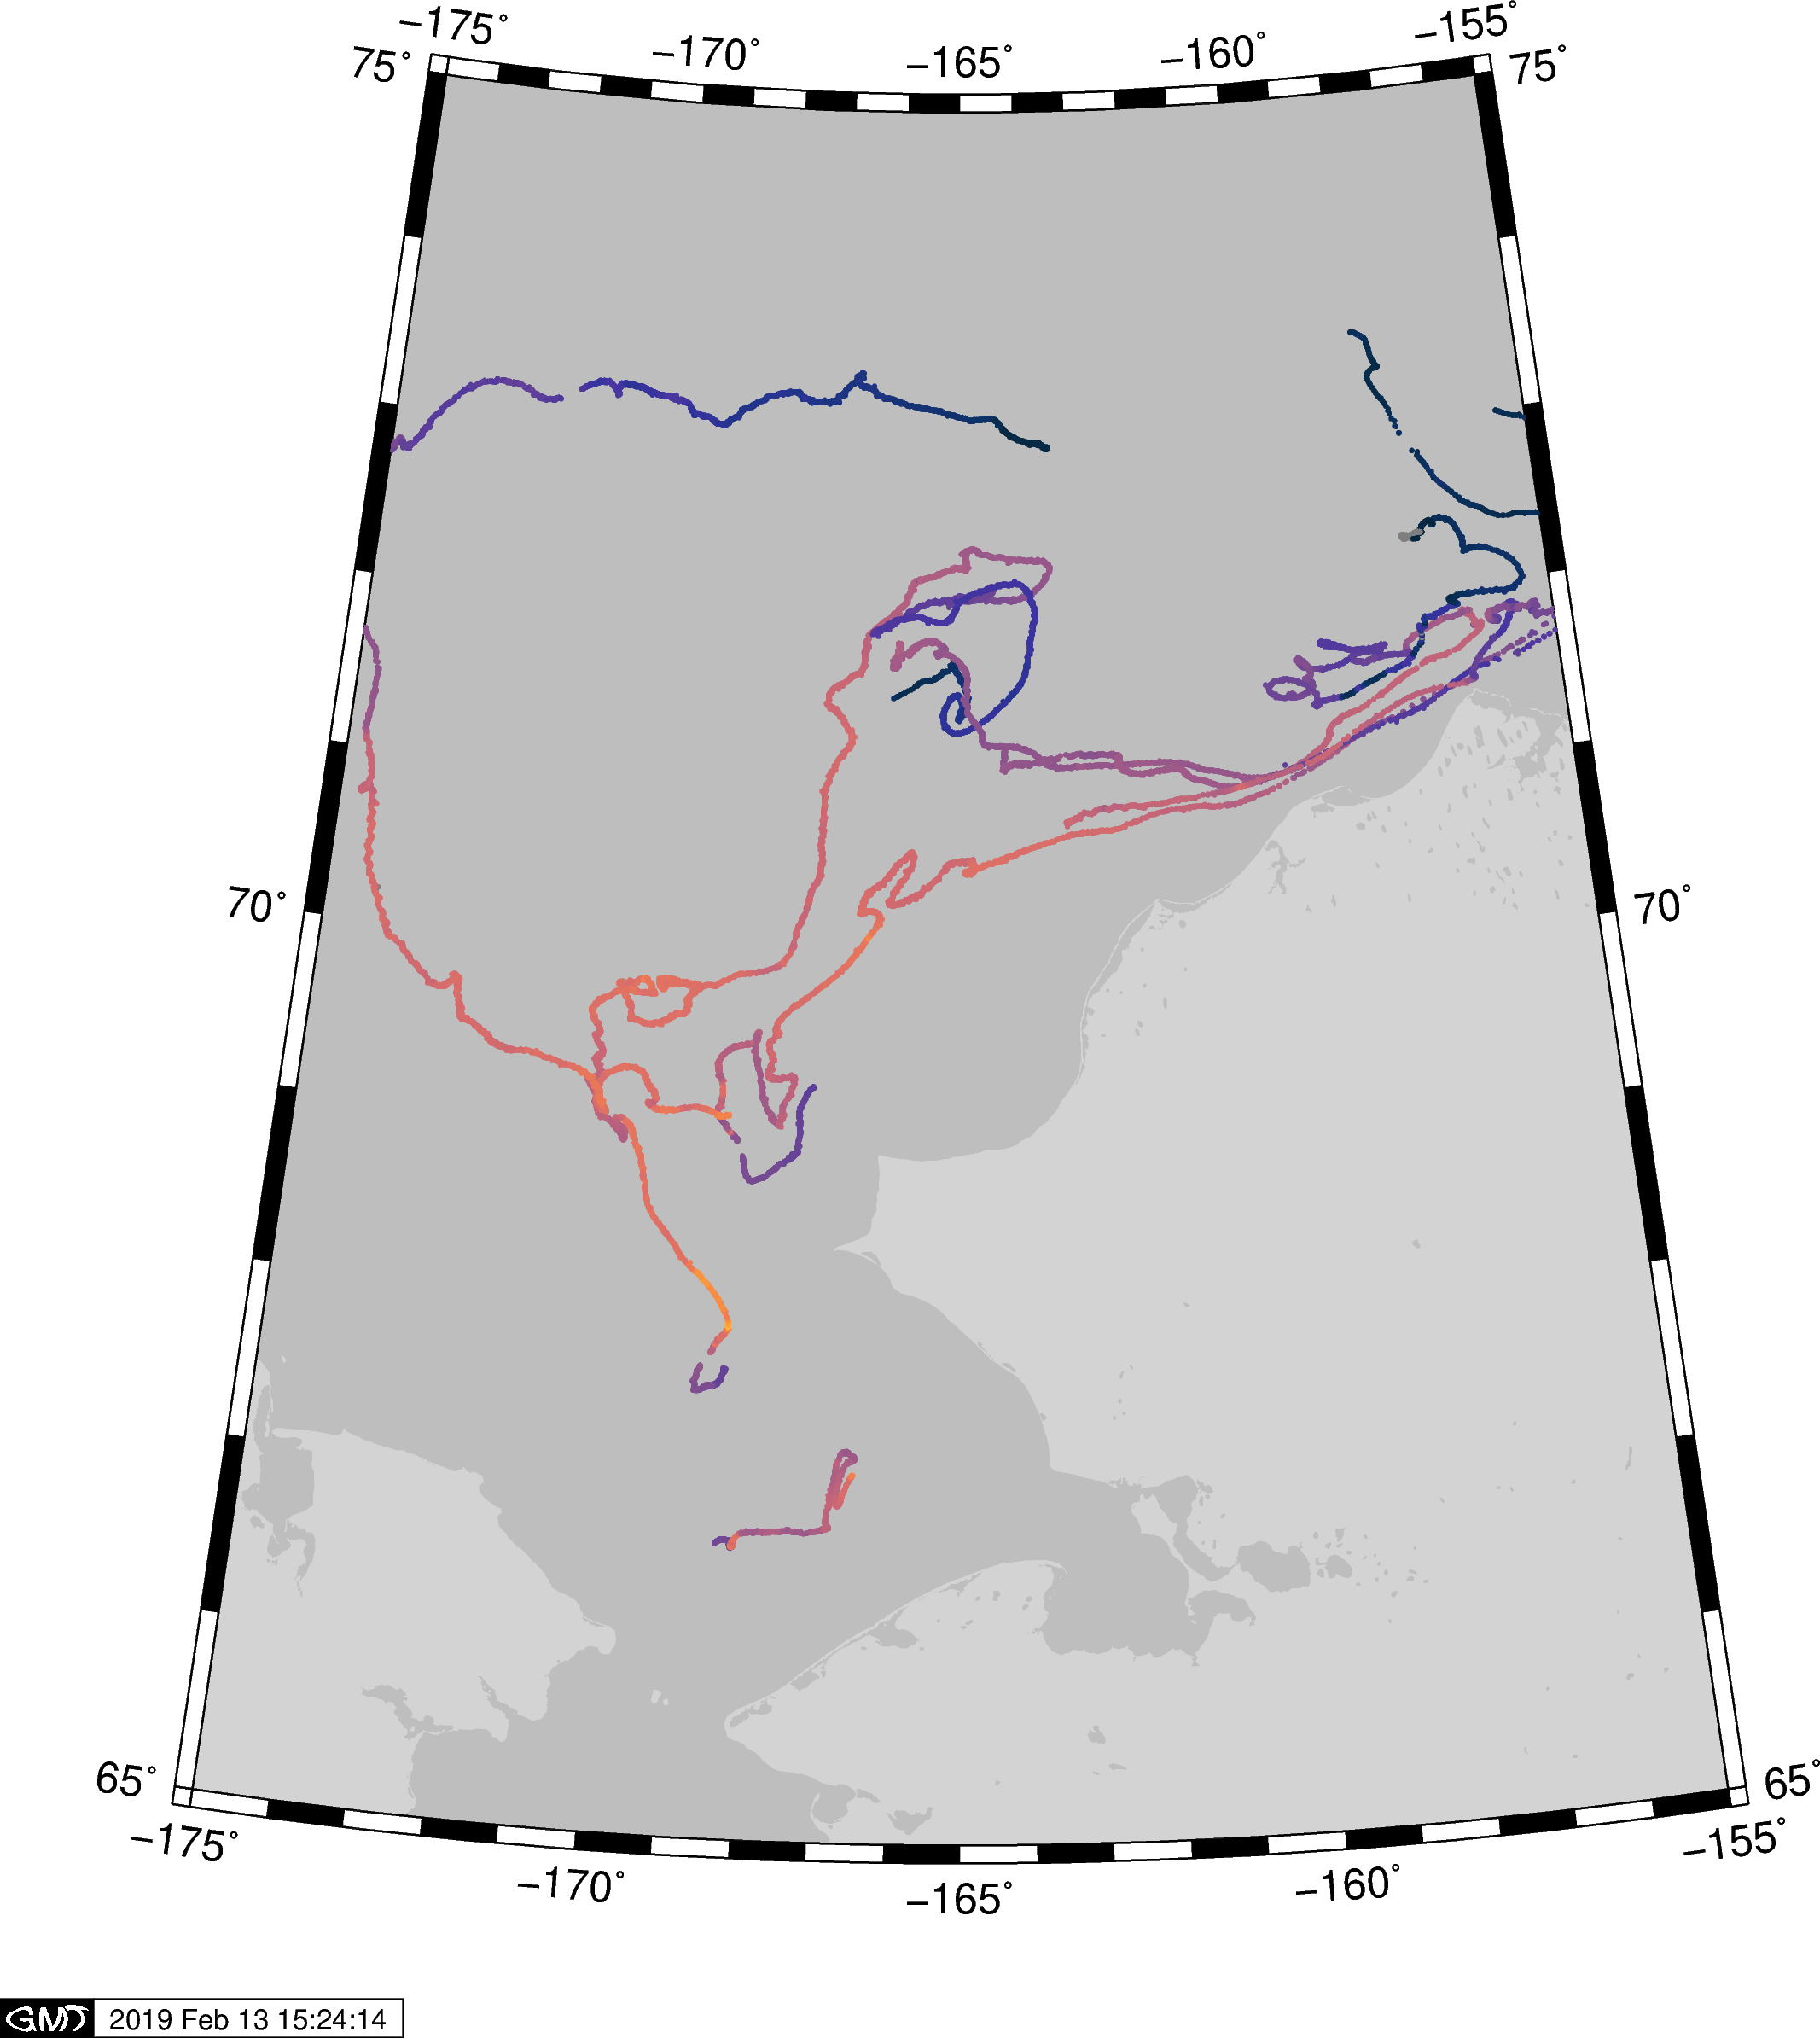

In [61]:
fig1.show()

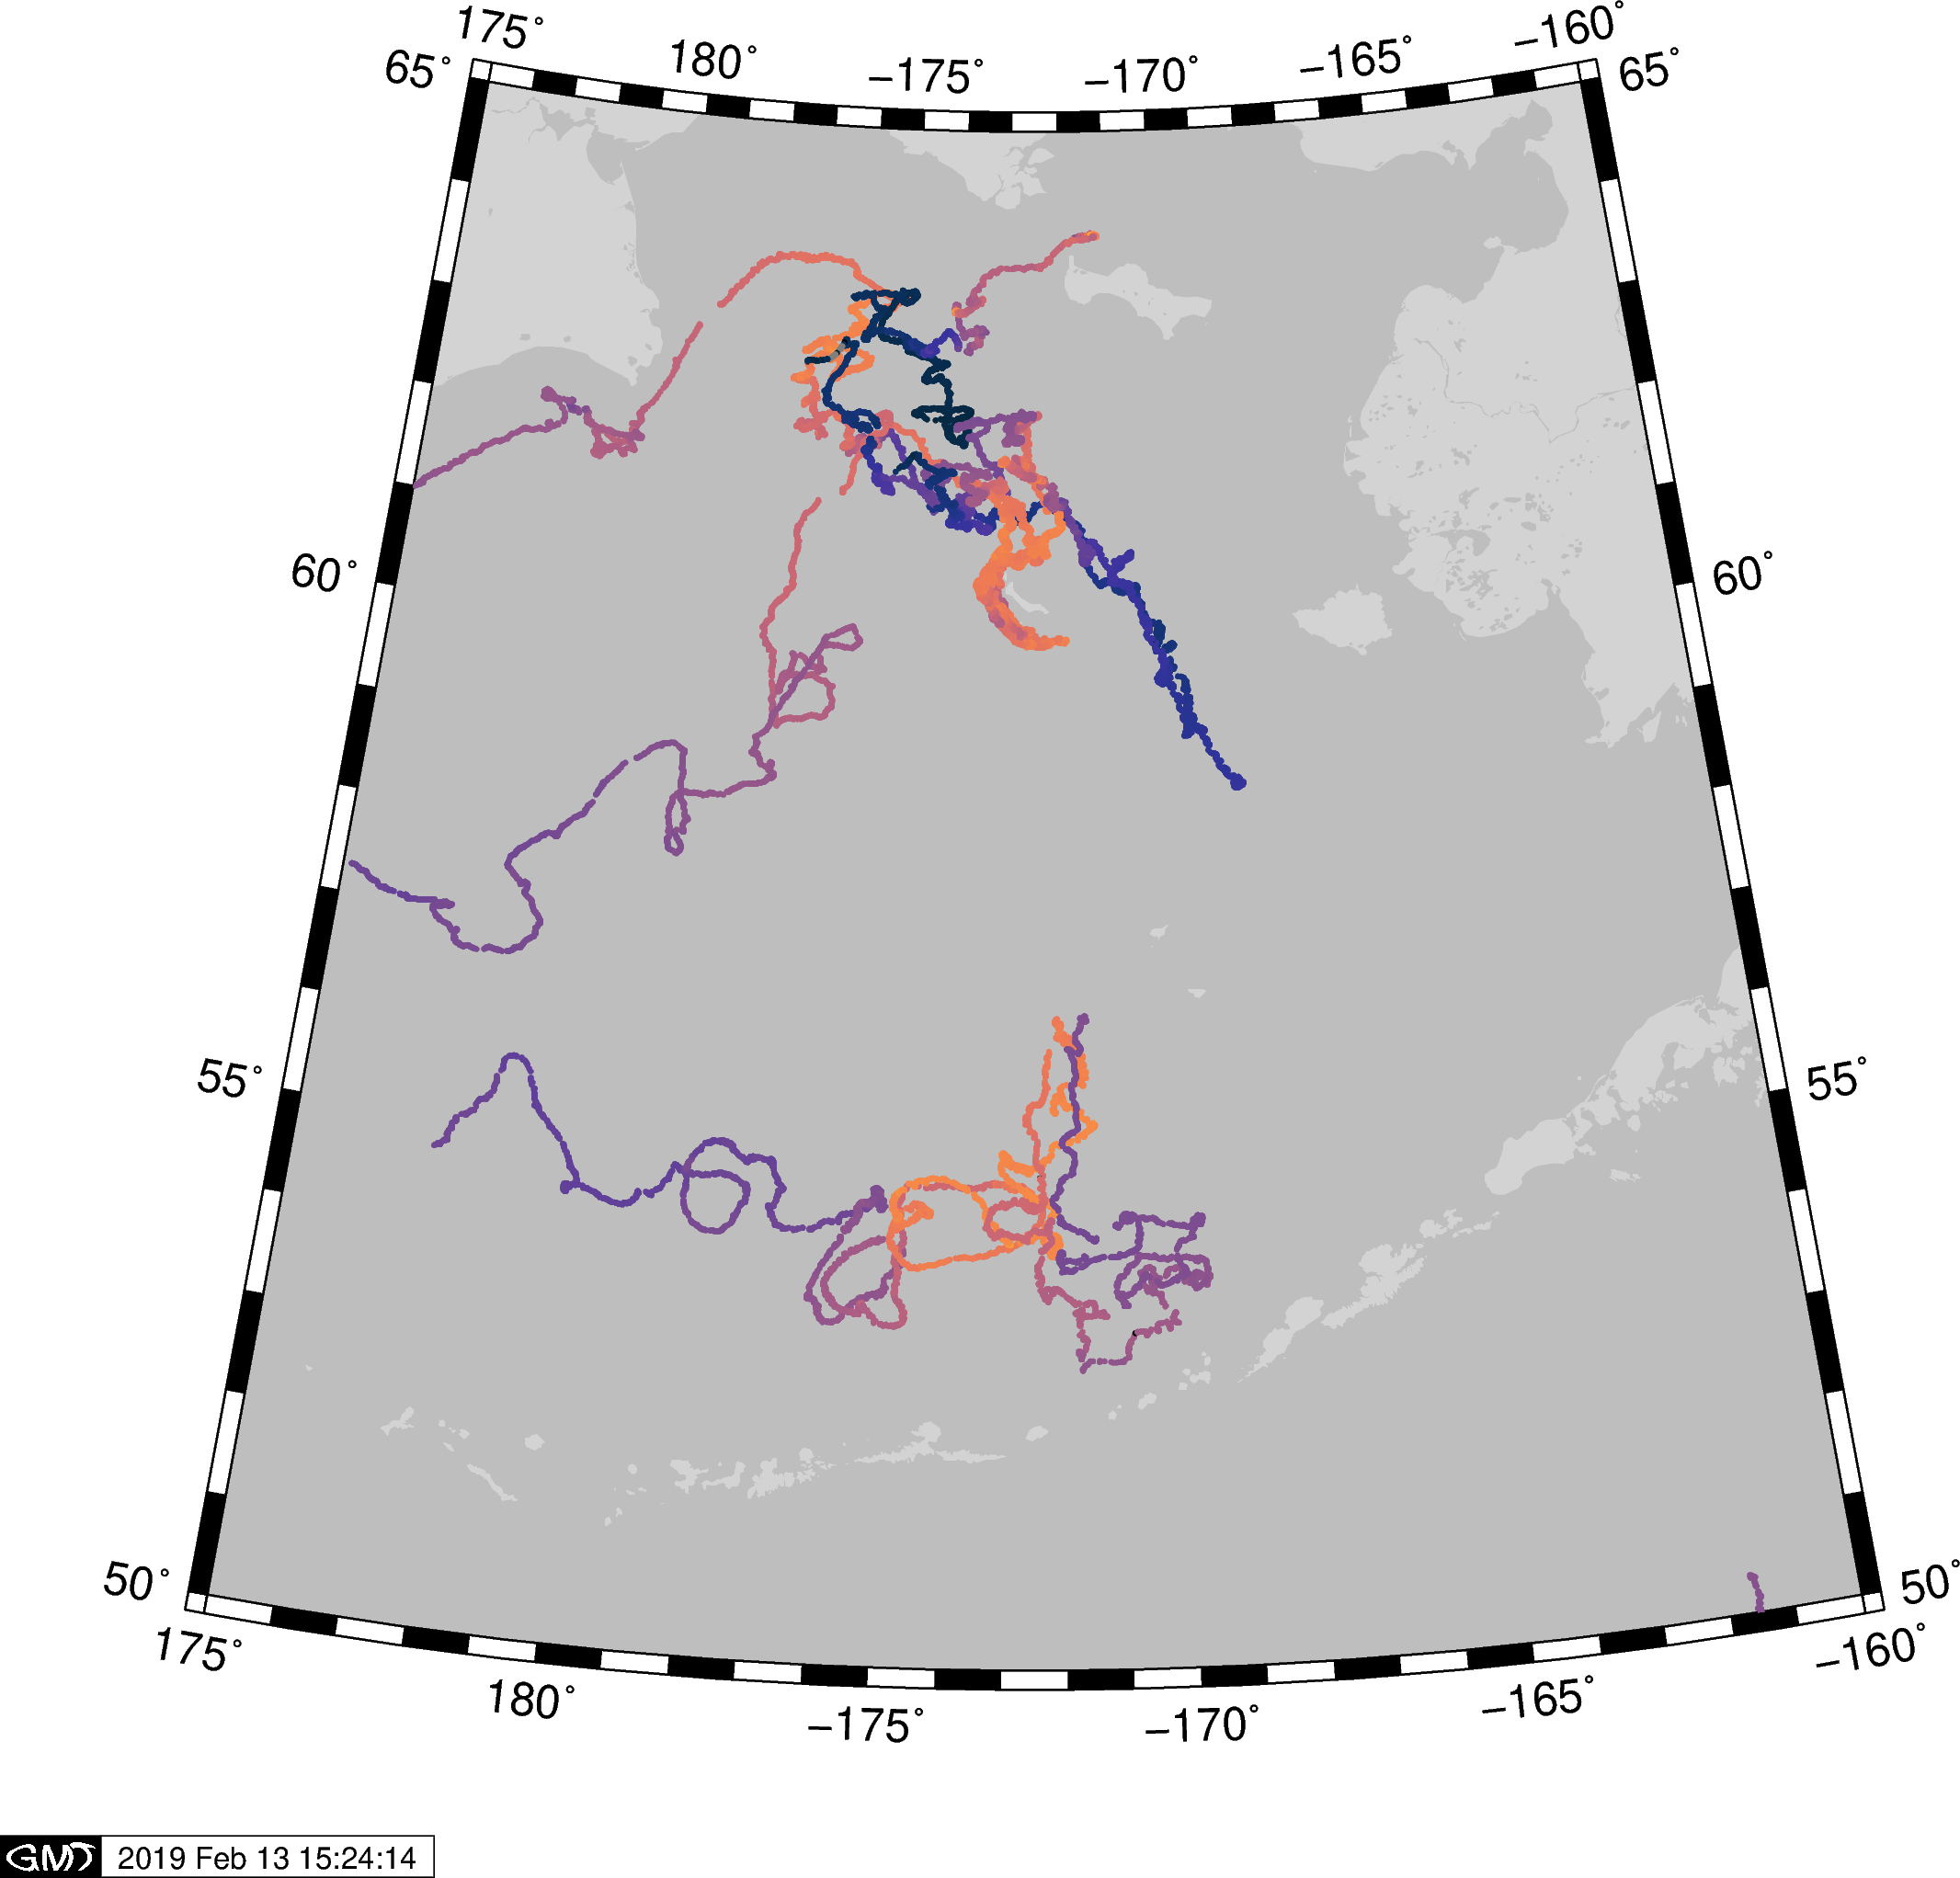

In [62]:
fig1b.show()

### Zoom in to Basins (Arctic and Bering) - DOY

In [63]:
fig1 = gmt.Figure()
fig1.coast(region=[-175, -155, 65, 75], projection='B-165/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

fig1b = gmt.Figure()
fig1b.coast(region=[-185, -160, 50, 65], projection='B-172.5/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

In [64]:
#color by doy
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss['dayofyear'] = dfmiss.index.dayofyear
    dfmiss['dayofyear'].loc[(df.index.dayofyear < 0) | (df.index.dayofyear > 366)] = np.nan
    # normalize data for colormap
    dfmiss['norm'] = dfmiss['dayofyear'].apply(lambda x: (x - (0)) / (366 - (0)))
    #plot a small '+' on mondays for data at '00'
    m_ind = (dfmiss.index.weekday_name == "Monday") & (dfmiss.index.hour == 0)
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfmiss['norm'], cmap='phase', style='c0.05c')
    fig1.plot(x=dfmiss[m_ind].longitude, y=dfmiss[m_ind].latitude, color='black', style='+0.25c')
    fig1b.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfmiss['norm'], cmap='phase', style='c0.05c')
    fig1b.plot(x=dfmiss[m_ind].longitude, y=dfmiss[m_ind].latitude, color='black', style='+0.25c')


/Users/bell/anaconda2/envs/gmt-python_v2/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/bell/anaconda2/envs/gmt-python_v2/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


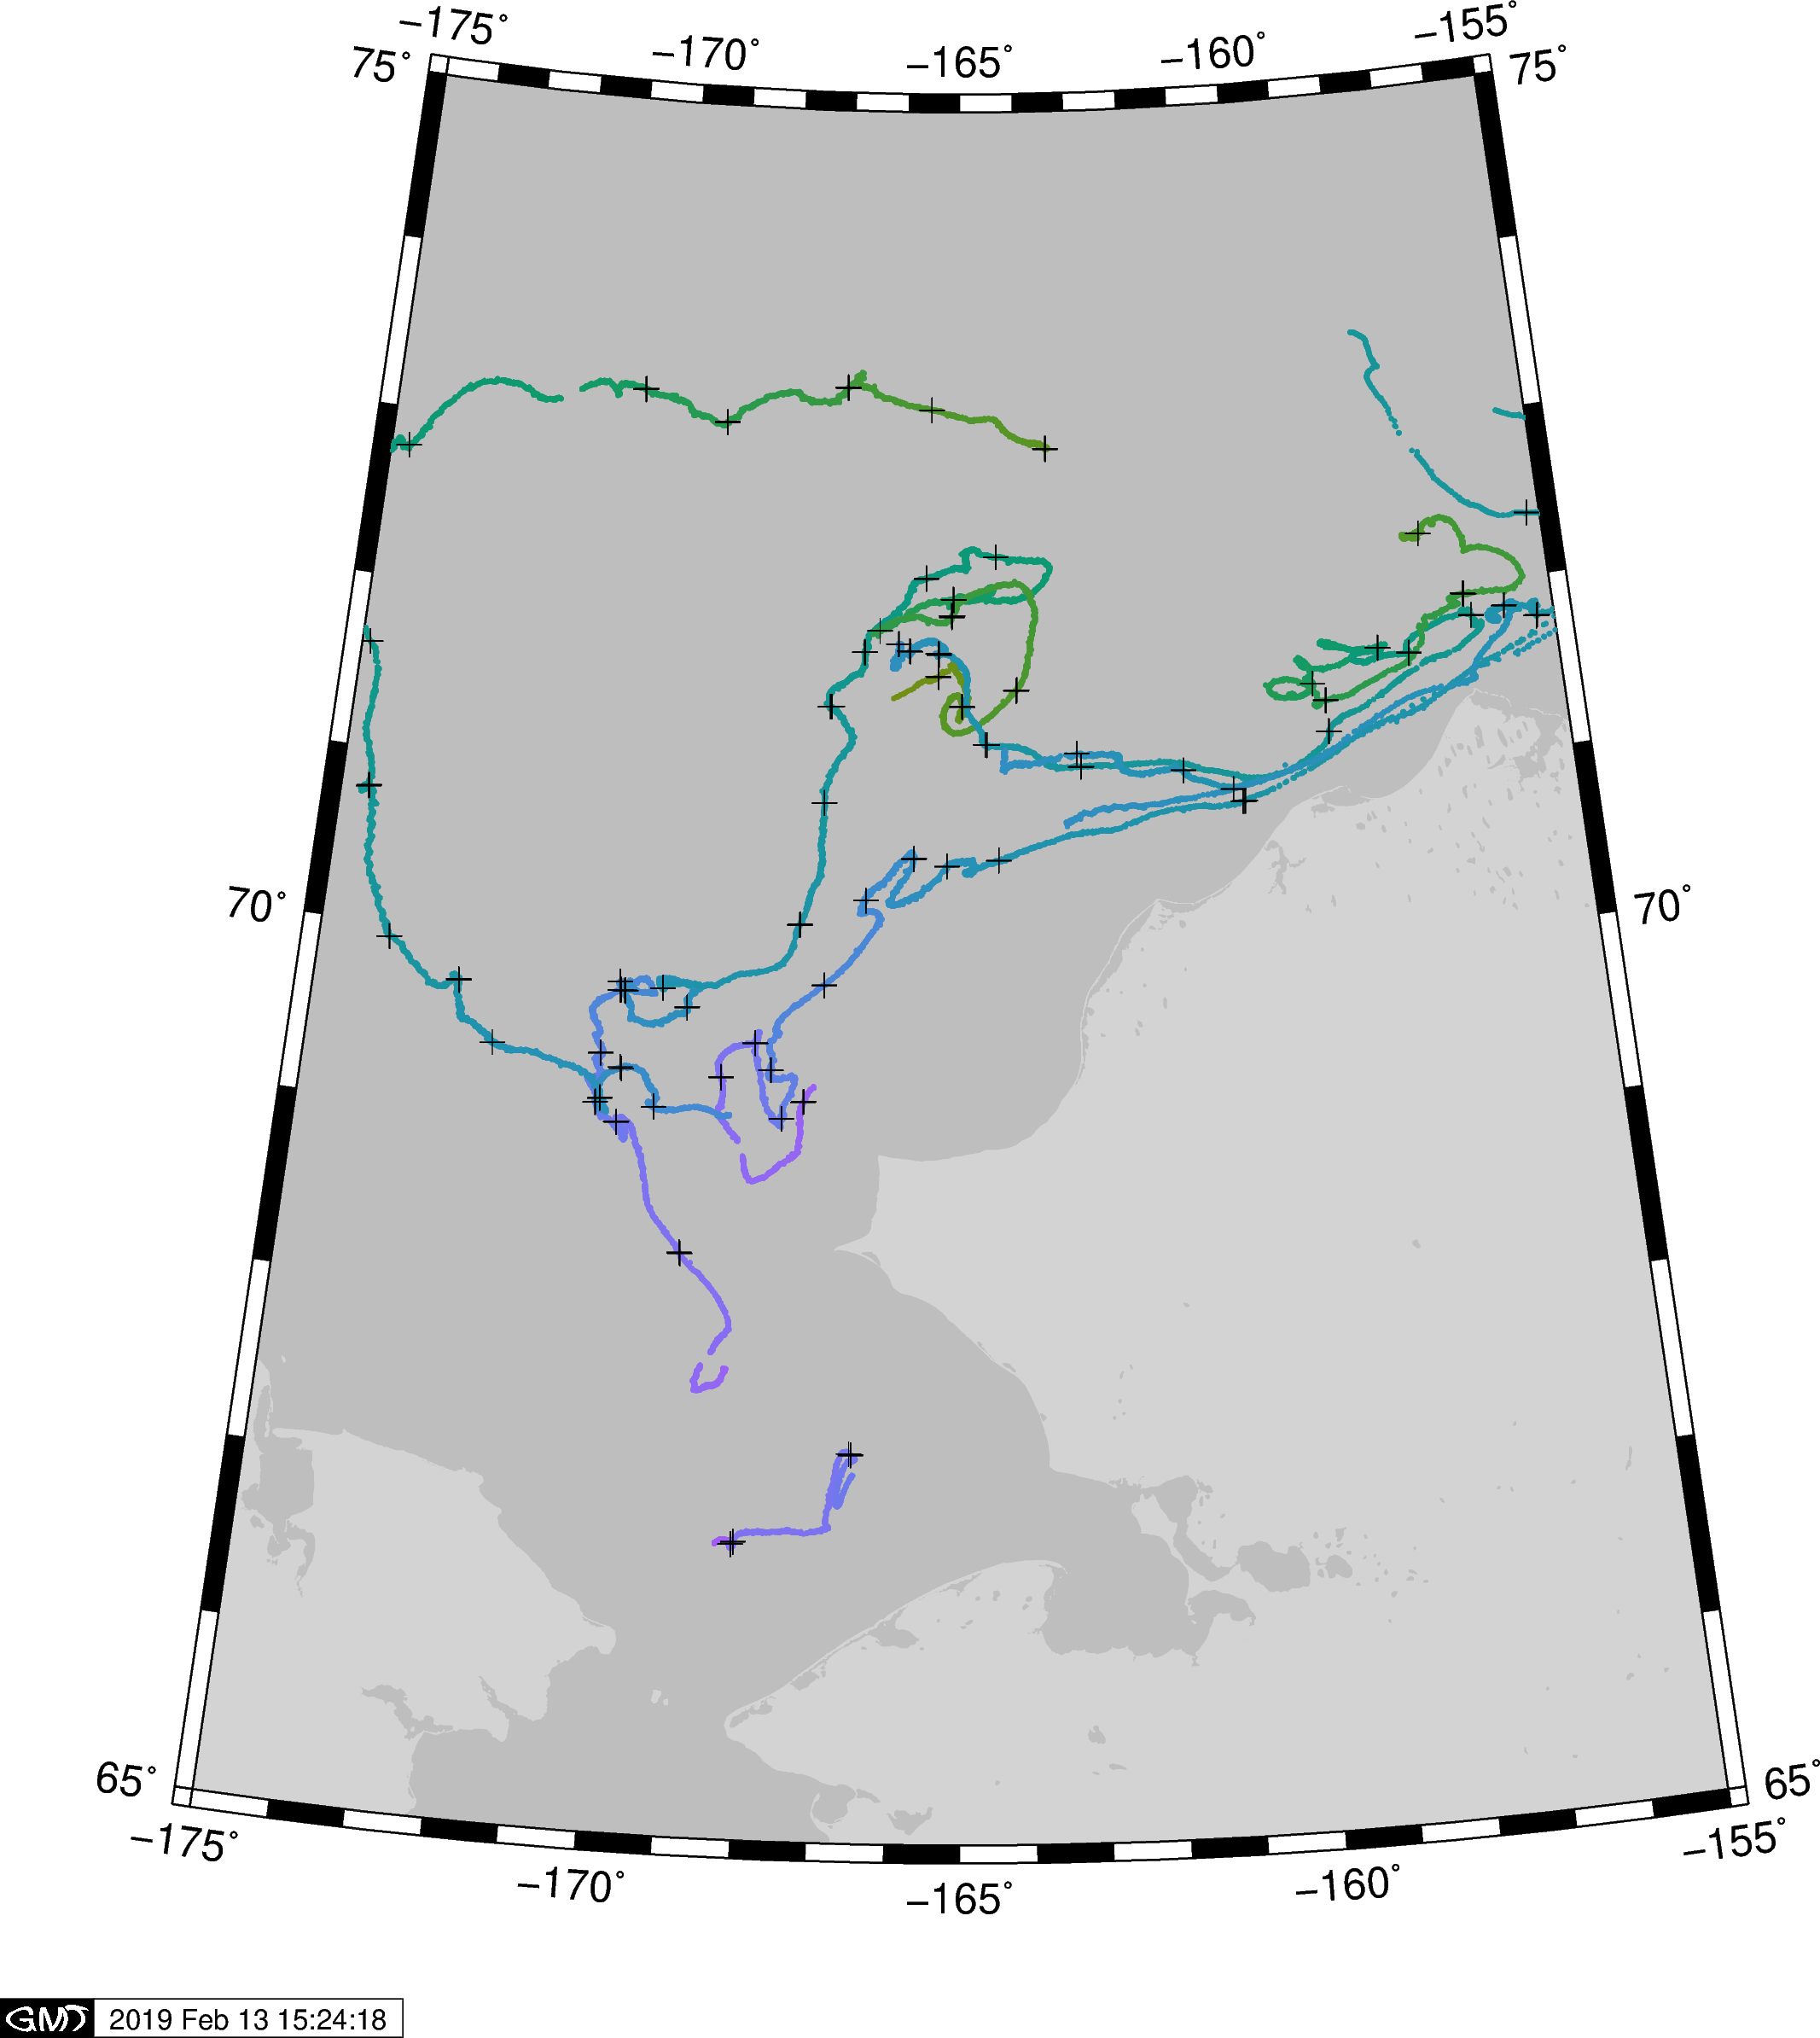

In [65]:
fig1.show()

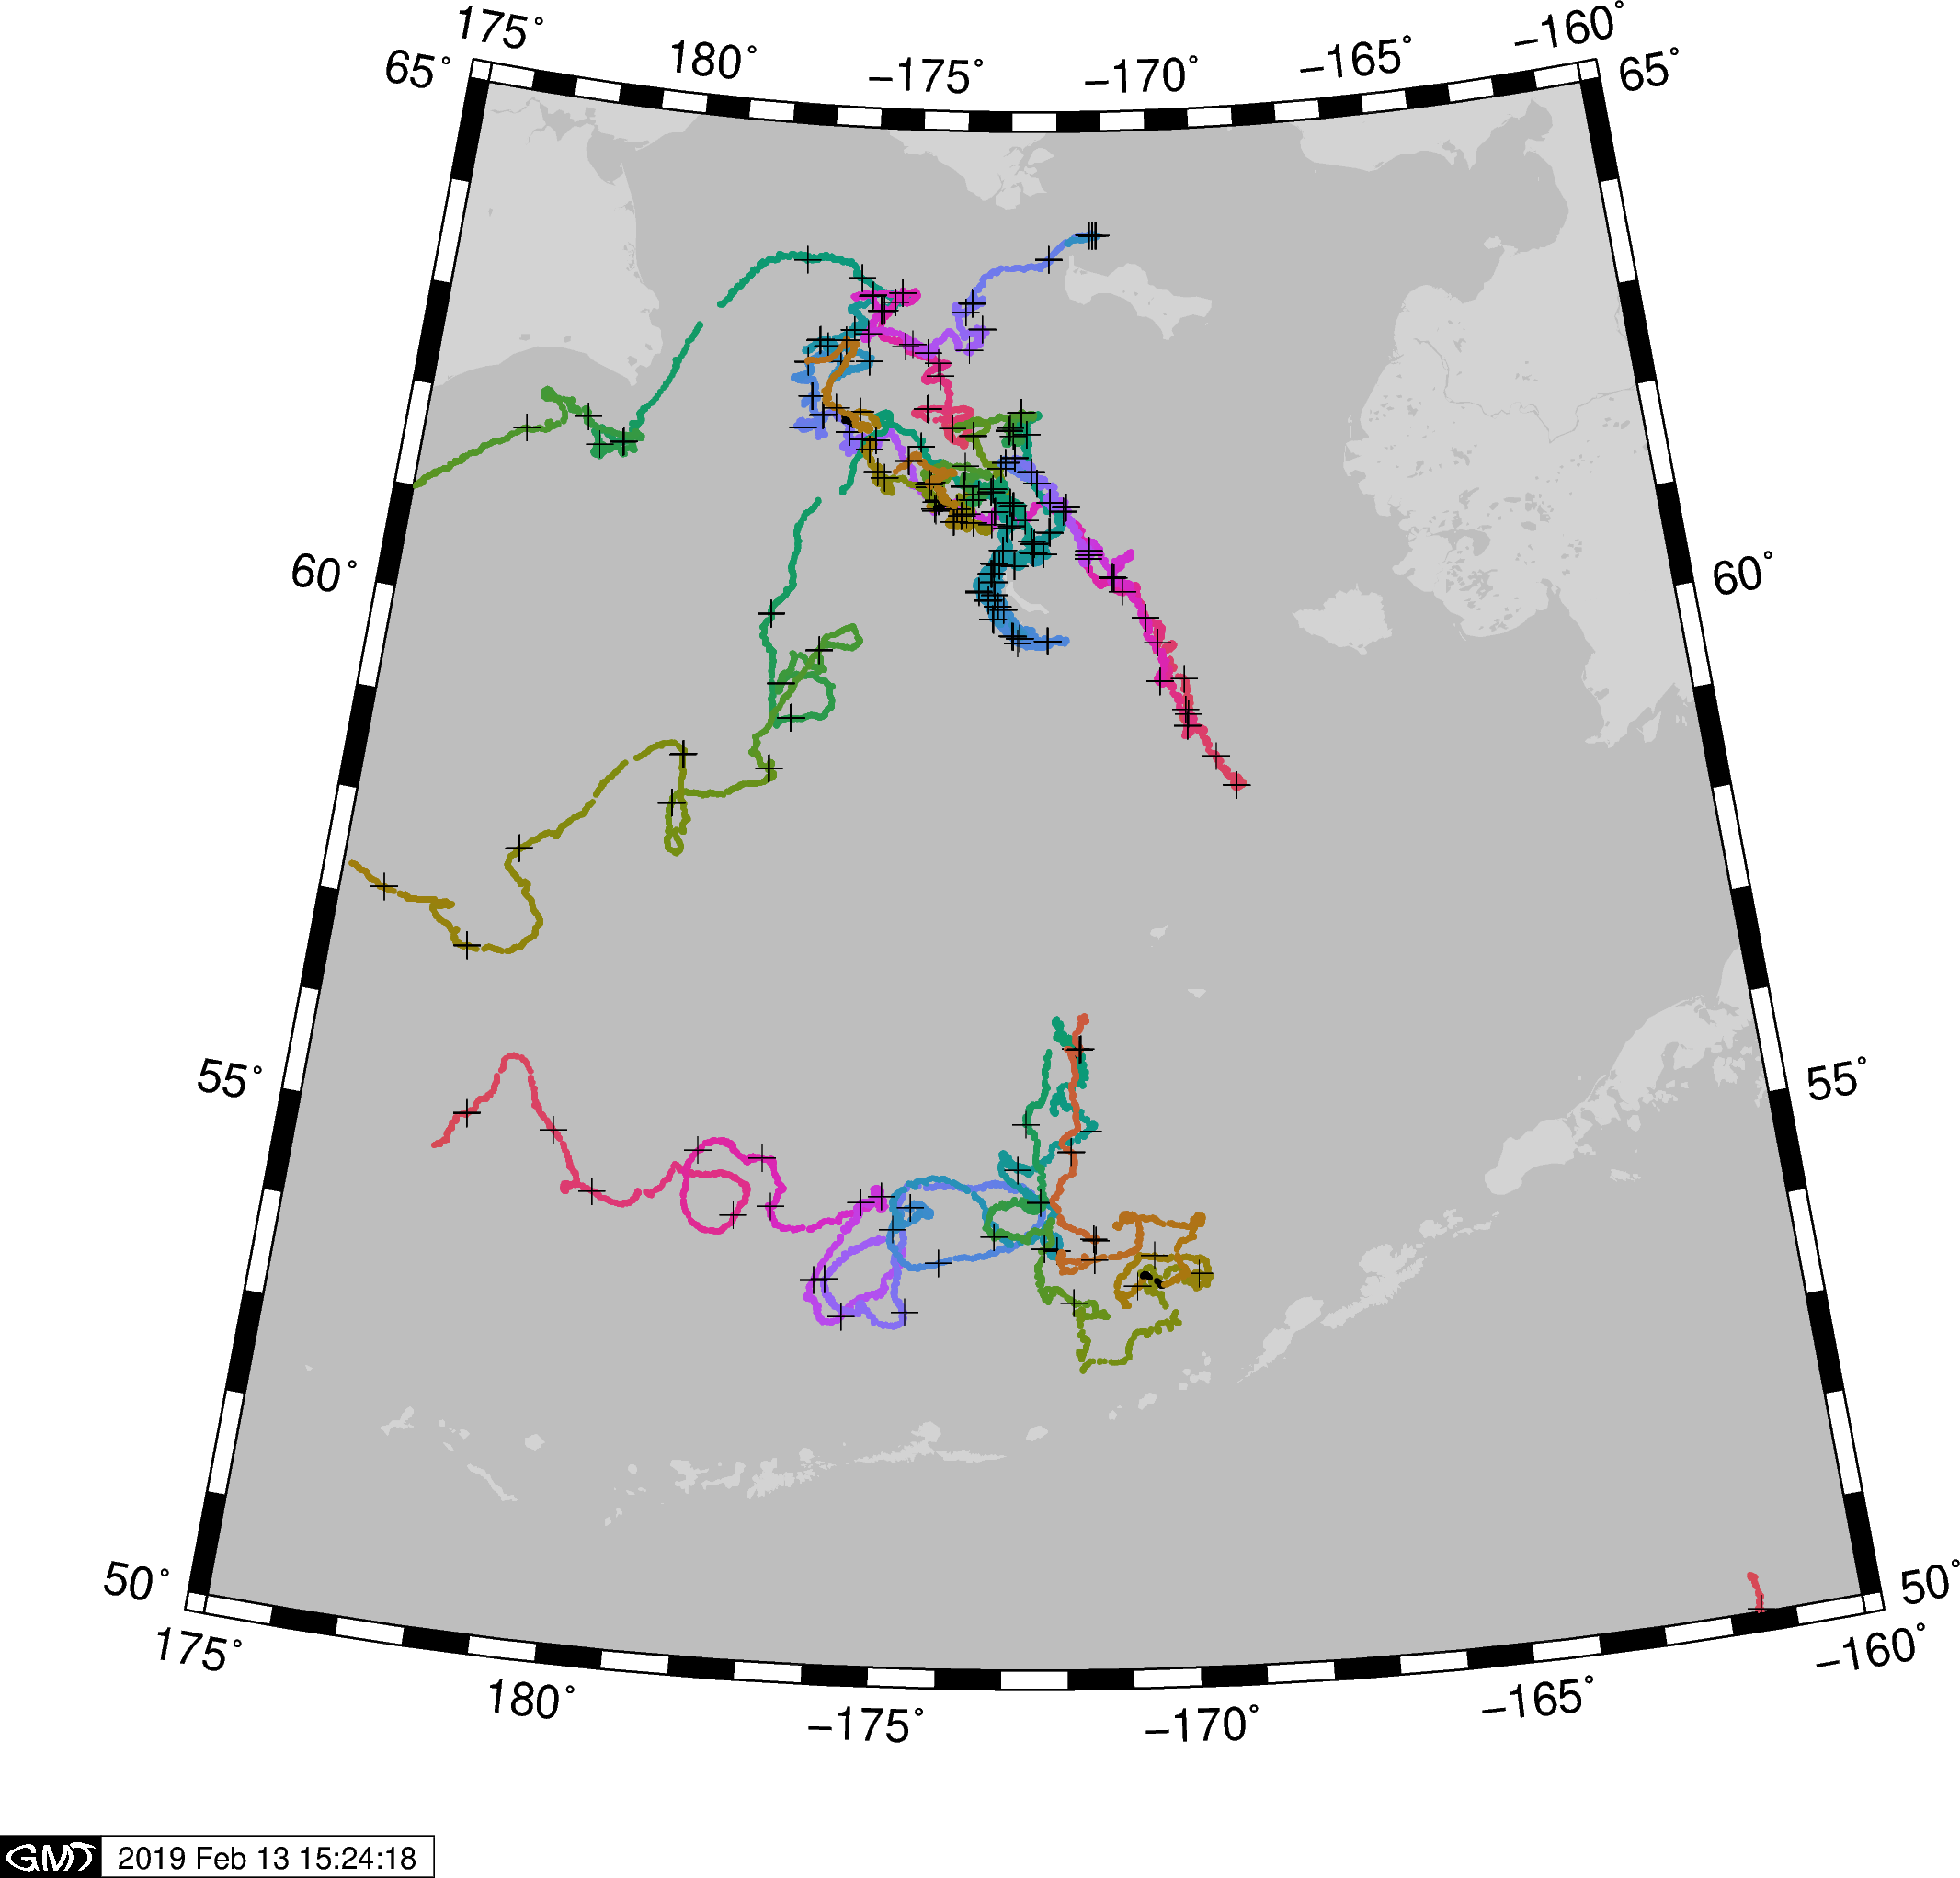

In [66]:
fig1b.show()

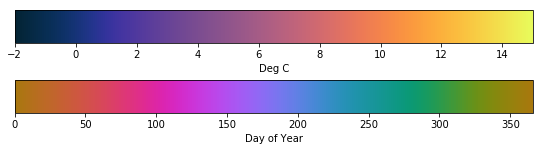

In [67]:
import cmocean
import matplotlib as mpl
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax2 = fig.add_axes([0.05, 0.475, 0.9, 0.15])
norm = mpl.colors.Normalize(vmin=-2, vmax=15)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmocean.cm.thermal,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Deg C')

norm = mpl.colors.Normalize(vmin=0, vmax=366)
cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmocean.cm.phase,
                                norm=norm,
                                orientation='horizontal')
cb2.set_label('Day of Year')